In [1]:
# Tb classifier using ground truth mask: Got similar level of accuracy and precision as when we use predicted masks
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
classes = ["normal", "ptb"]

In [5]:
import tensorflow as tf

In [6]:
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": classes
}

In [7]:
# Accessing train and test datasets
train = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Classifier_Input_GT",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/Classifier_Input_GT",
  subset="validation",
    **args
)

Found 553 files belonging to 2 classes.
Using 443 files for training.
Found 553 files belonging to 2 classes.
Using 110 files for validation.


In [8]:
first = train.take(1)
first

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [9]:
images, labels = list(first)[0]
first_image = images[0]

In [10]:
first_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

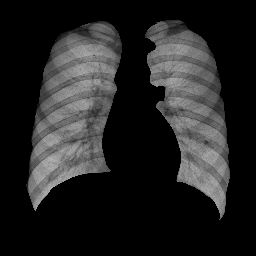

In [11]:
from PIL import Image

Image.fromarray(images[0].numpy().astype("uint8"))

In [12]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Making a simple sequential model
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(classes))
])

In [14]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
history = model.fit(
    train,
    validation_data=test,
    epochs=10,
    verbose=1
)

Epoch 1/10
14/14 [==============================] - 57s 3s/step - loss: 1.3409 - accuracy: 0.6614 - val_loss: 0.6742 - val_accuracy: 0.5273
Epoch 2/10
14/14 [==============================] - 23s 2s/step - loss: 0.6436 - accuracy: 0.6433 - val_loss: 0.6032 - val_accuracy: 0.7000
Epoch 3/10
14/14 [==============================] - 23s 2s/step - loss: 0.5782 - accuracy: 0.7088 - val_loss: 0.5475 - val_accuracy: 0.7455
Epoch 4/10
14/14 [==============================] - 25s 2s/step - loss: 0.5395 - accuracy: 0.7404 - val_loss: 0.5288 - val_accuracy: 0.7545
Epoch 5/10
14/14 [==============================] - 23s 2s/step - loss: 0.5186 - accuracy: 0.7381 - val_loss: 0.5188 - val_accuracy: 0.7636
Epoch 6/10
14/14 [==============================] - 23s 2s/step - loss: 0.5008 - accuracy: 0.7427 - val_loss: 0.5307 - val_accuracy: 0.7273
Epoch 7/10
14/14 [==============================] - 23s 2s/step - loss: 0.5332 - accuracy: 0.7269 - val_loss: 0.5309 - val_accuracy: 0.7273
Epoch 8/10
14/14 [==

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 134,218,562
Trainable params: 134,218,562
Non-trainable params: 0
_________________________________________________________________


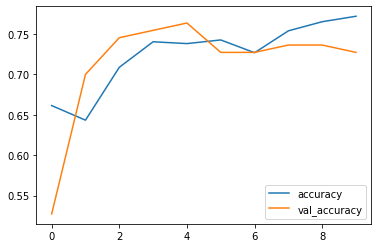

In [17]:
import pandas as pd

history_df = pd.DataFrame.from_dict(history.history)
history_df[["accuracy", "val_accuracy"]].plot()


In [18]:
def train_model(network, epochs=15):
    model = Sequential(network)

    model.compile(optimizer='sgd',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

In [ ]:
# Defining the network and layers in detail

network = [
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 4, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(classes))
]

history_df, model = train_model(network)

Epoch 1/15
14/14 [==============================] - 41s 3s/step - loss: 0.6757 - accuracy: 0.5440 - val_loss: 0.6567 - val_accuracy: 0.5545
Epoch 2/15
14/14 [==============================] - 43s 3s/step - loss: 0.6311 - accuracy: 0.6569 - val_loss: 0.6028 - val_accuracy: 0.6636
Epoch 3/15
14/14 [==============================] - 43s 3s/step - loss: 0.5905 - accuracy: 0.6749 - val_loss: 0.5628 - val_accuracy: 0.7182
Epoch 4/15
14/14 [==============================] - 41s 3s/step - loss: 0.5681 - accuracy: 0.6953 - val_loss: 0.5492 - val_accuracy: 0.7273
Epoch 5/15
14/14 [==============================] - 41s 3s/step - loss: 0.5602 - accuracy: 0.7065 - val_loss: 0.5467 - val_accuracy: 0.7182
Epoch 6/15
14/14 [==============================] - 43s 3s/step - loss: 0.5427 - accuracy: 0.7111 - val_loss: 0.5389 - val_accuracy: 0.7273
Epoch 7/15
14/14 [==============================] - 41s 3s/step - loss: 0.5351 - accuracy: 0.7178 - val_loss: 0.5385 - val_accuracy: 0.7364
Epoch 8/15
14/14 [==

In [ ]:
history_df[["accuracy", "val_accuracy"]].plot()

In [ ]:
model.summary()

In [22]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("vertical", seed=1),
      layers.RandomRotation(0.2, seed=1),
    layers.RandomZoom(0.2, seed=1),
  ]
)


full_network = [
    data_augmentation
] + network

history_df, model = train_model(full_network, epochs=40)

Epoch 1/40
14/14 [==============================] - 48s 3s/step - loss: 0.6629 - accuracy: 0.6185 - val_loss: 0.5629 - val_accuracy: 0.6636
Epoch 2/40
14/14 [==============================] - 45s 3s/step - loss: 0.5955 - accuracy: 0.6749 - val_loss: 0.5547 - val_accuracy: 0.6727
Epoch 3/40
14/14 [==============================] - 46s 3s/step - loss: 0.5657 - accuracy: 0.7201 - val_loss: 0.5236 - val_accuracy: 0.7455
Epoch 4/40
14/14 [==============================] - 45s 3s/step - loss: 0.5627 - accuracy: 0.7133 - val_loss: 0.5371 - val_accuracy: 0.7091
Epoch 5/40
14/14 [==============================] - 45s 3s/step - loss: 0.5412 - accuracy: 0.7133 - val_loss: 0.5286 - val_accuracy: 0.7545
Epoch 6/40
14/14 [==============================] - 46s 3s/step - loss: 0.5700 - accuracy: 0.6975 - val_loss: 0.5340 - val_accuracy: 0.7182
Epoch 7/40
14/14 [==============================] - 46s 3s/step - loss: 0.5528 - accuracy: 0.7178 - val_loss: 0.5319 - val_accuracy: 0.7364
Epoch 8/40
14/14 [==

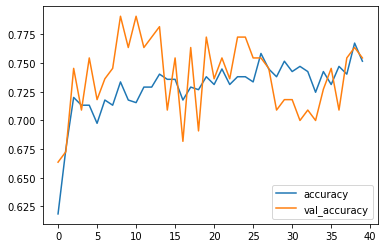

In [23]:
history_df[["accuracy", "val_accuracy"]].plot()

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [25]:
preds = model.predict(test)

4/4 [==============================] - 3s 576ms/step


In [26]:
import numpy as np
predicted_class = np.argmax(preds, axis=1)

In [27]:
actual_labels = np.concatenate([y for x, y in test], axis=0)

In [28]:
import itertools

actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [29]:
actual_class = np.argmax(actual_labels, axis=1)

In [30]:
pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=["prediction", "actual", "image"])

In [31]:
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: classes[x])
pred_df["actual"] = pred_df["actual"].apply(lambda x: classes[x])

In [32]:
import base64
import io

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'{img_str}">'

pred_df.head(10).style.format({'image': image_formatter})

In [33]:
from sklearn import metrics
# Predicted values
y_pred = pred_df["prediction"]
# Actual values
y_act = pred_df["actual"]
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(y_act, y_pred, labels=["normal", "ptb"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=["normal", "ptb"]))

[[45 13]
 [14 38]]
              precision    recall  f1-score   support

      normal       0.76      0.78      0.77        58
         ptb       0.75      0.73      0.74        52

    accuracy                           0.75       110
   macro avg       0.75      0.75      0.75       110
weighted avg       0.75      0.75      0.75       110

